In [52]:
import io
import numpy as np

In [53]:
from torch import nn
import torch.onnx

In [54]:
from PIL import Image
import torchvision.transforms as transforms

In [55]:
import torch.nn.init as init

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
import onnx
import os

In [58]:
class Network(nn.Module):
    def __init__(self, upscale_factor):
        super(Network, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x
    
    # A way to initialize weights. Read more here: https://pytorch.org/docs/stable/_modules/torch/nn/init.html#orthogonal_
    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

In [59]:
torch_model = Network(upscale_factor=3)      # Initialize the model

In [60]:
Path = '/workspace/nagaraj/model_epoch_599.pth'          # path to the pretrained model

In [61]:
torch_model = torch.load(Path)       

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:563: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:563: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:563: SourceChangeWarning: source code of class 'torch.nn.modules.pixelshuffle.PixelShuffle' has changed. you can retrieve the original source code by accessing the object's source attribute or

In [62]:
torch_model.eval()           # Set to eval mode, since some operators behave differently in test and training mode.

Network(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

We first trace our model to export it to the onnx format. This is done by passing a dummy variable (of proper size) as input to the model. The onnx model also stores the learned parameters and the various operations that contribute to the output. The input size will be fixed in the exported ONNX graph for all the input dimensions. If the model has variable parameters like batch_size, we can specify that as dynamic axes.   

In [63]:
batch_size = 1 # set as a random number initially (it is set as dynamic axes later)
# Input to the model
x = torch.randn(batch_size, 1, 224, 224, requires_grad=True).cuda() # moving the tensor to GPU
torch_out = torch_model(x)    # storing the model output to compare with the onnx model output

# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes 
                                'output' : {0 : 'batch_size'}})


In [64]:
onnx_model = onnx.load("super_resolution.onnx")
onnx.checker.check_model(onnx_model)

In [65]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("super_resolution.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
# ort_outs gives a list of outputs. We are selecting the first one, since we have one output.
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [66]:
#os.listdir()

In [67]:
img = Image.open("Cat_image.jpeg")

resize = transforms.Resize([224, 224])
img = resize(img)

img_ycbcr = img.convert('YCbCr')
img_y, img_cb, img_cr = img_ycbcr.split()

to_tensor = transforms.ToTensor()
img_y = to_tensor(img_y)
img_y.unsqueeze_(0)

tensor([[[[0.3490, 0.3451, 0.3373,  ..., 0.1490, 0.1373, 0.1020],
          [0.3451, 0.3373, 0.3294,  ..., 0.1490, 0.1373, 0.1020],
          [0.3255, 0.3176, 0.3098,  ..., 0.1490, 0.1333, 0.1020],
          ...,
          [0.5686, 0.5804, 0.5922,  ..., 0.5098, 0.4941, 0.4902],
          [0.5569, 0.5647, 0.5725,  ..., 0.5059, 0.4902, 0.4824],
          [0.5020, 0.5216, 0.5412,  ..., 0.5020, 0.4980, 0.4863]]]])

In [68]:
'''A PyTorch Tensor is basically the same as a numpy array: it does not know anything about deep learning or 
computational graphs or gradients, and is just a generic n-dimensional array to be used for arbitrary numeric 
computation.'''
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_y)}     # The input must be a numpy array 
ort_outs = ort_session.run(None, ort_inputs)
img_out_y = ort_outs[0]

In [69]:
img_out_y = Image.fromarray(np.uint8((img_out_y[0] * 255.0).clip(0, 255)[0]), mode='L')

final_img = Image.merge("YCbCr", [img_out_y,
                                  img_cb.resize(img_out_y.size, Image.BICUBIC),
                                  img_cr.resize(img_out_y.size, Image.BICUBIC),
                                 ]).convert("RGB")

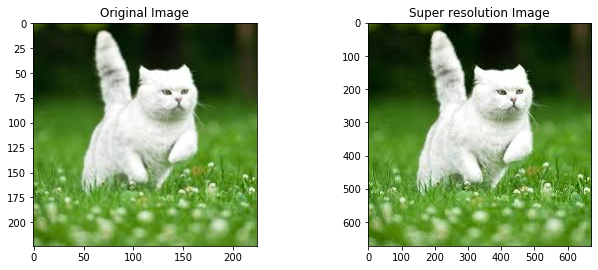

In [70]:
fig=plt.figure(figsize=[10,5])
    
fig.add_subplot(1, 2, 1, title='Original Image')
plt.imshow(img)

fig.add_subplot(1, 2, 2, title='Super resolution Image')
plt.imshow(final_img)
'''
fig.add_subplot(2, 3, 3, title='y component')
plt.imshow(out_img_y)

fig.add_subplot(2, 3, 4, title='cb')
plt.imshow(out_img_cb)

fig.add_subplot(2, 3, 5, title='cr')
plt.imshow(out_img_cr)

fig.add_subplot(2, 3, 6, title='ycbcr from rgb')
plt.imshow(img_normal)'''

fig.subplots_adjust(wspace = 0.5)
plt.show()

In [71]:
final_img.save("/workspace/nagaraj/cat_superres_with_ort.jpg")